## Cats vs Dogs partial - CNN
- 부분 데이터 - 고양이: 1000 + 500, 개: 1000 + 500

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-11-08 06:05:36--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.207, 108.177.126.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  28.2MB/s    in 2.3s    

2023-11-08 06:05:39 (28.2 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
!unzip cats_and_dogs_filtered.zip > /dev/null

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2023
np.random.seed(seed)
tf.random.set_seed(seed)

- 데이터 탐색

In [4]:
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [5]:
# 파일의 갯수
import os

for dir in [train_cats_dir,train_dogs_dir,validation_cats_dir,validation_dogs_dir]:
    fnames = os.listdir(dir)
    print(f'{dir}: {len(fnames):,d}')

cats_and_dogs_filtered/train/cats: 1,000
cats_and_dogs_filtered/train/dogs: 1,000
cats_and_dogs_filtered/validation/cats: 500
cats_and_dogs_filtered/validation/dogs: 500


- 이미지 확인

In [6]:
fname = os.path.join(train_cats_dir, 'cat.475.jpg')
fname

'cats_and_dogs_filtered/train/cats/cat.475.jpg'

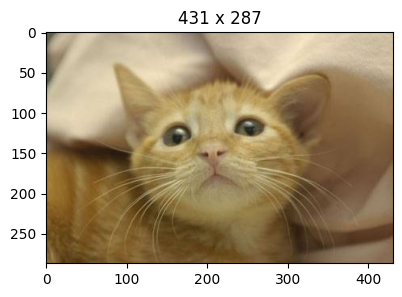

In [7]:
# 1) Pillow Image
from PIL import Image
img = Image.open(fname)
plt.figure(figsize=(5,3))
plt.title(f'{img.width} x {img.height}')
plt.imshow(img);

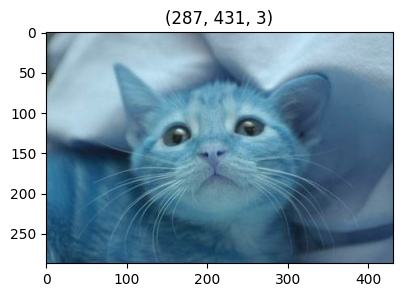

In [8]:
# 2) OpenCV image: 순서가 RGB가 아니고 BGR
import cv2
img2 = cv2.imread(fname)
plt.figure(figsize=(5,3))
plt.title(img2.shape)       # OpenCV로 읽으면 numpy ndarray로 읽힘
plt.imshow(img2);

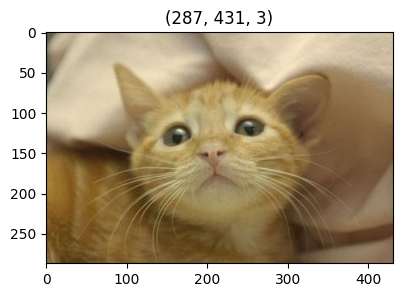

In [9]:
img2 = cv2.imread(fname)
plt.figure(figsize=(5,3))
plt.title(img2.shape)
plt.imshow(img2[:,:,::-1]);

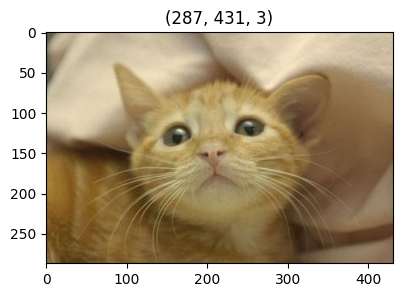

In [10]:
plt.figure(figsize=(5,3))
plt.title(img2.shape)
img3 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
plt.imshow(img3);

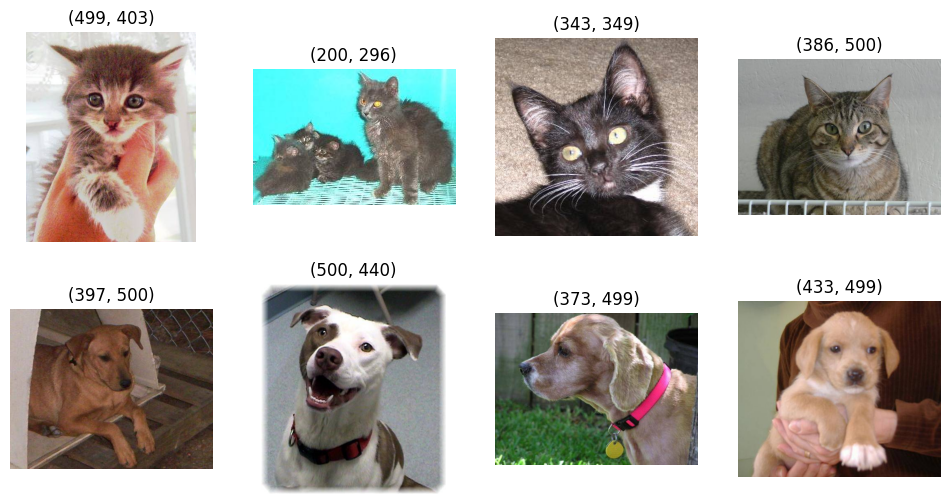

In [11]:
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(f'{train_cats_dir}/cat.10{i}.jpg')[:,:,::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])
    plt.subplot(2, 4, i+5)
    dog = cv2.imread(f'{train_dogs_dir}/dog.10{i}.jpg')[:,:,::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])
plt.show()

- 모델 구성

In [12]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
model = Sequential([
    Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'),  # 이미지를 150x150의 크기로 변환해주는 무언가가 필요함
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [14]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model_path = 'best-cats-and-dogs.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

- 파일에서 이미지 데이터를 읽어서 학습시키는 방법

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [16]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'

train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
test_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


- 모델 학습

In [18]:
hist = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    steps_per_epoch=100,        # batch_size(20) x steps_per_epoch(100) = 2000, 트레인 데이터가 2,000개
    validation_steps=50,        # batch_size(20) x validation_steps(50) = 1000, 검증 데이터가 1,000개
    callbacks=[mc, es]
)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.5100
Epoch 1: val_loss improved from inf to 0.69042, saving model to best-cats-and-dogs.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 19s 61ms/step - loss: 0.7106 - accuracy: 0.5100 - val_loss: 0.6904 - val_accuracy: 0.5440
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.6784 - accuracy: 0.5763
Epoch 2: val_loss improved from 0.69042 to 0.64937, saving model to best-cats-and-dogs.h5
100/100 [==============================] - 8s 77ms/step - loss: 0.6786 - accuracy: 0.5755 - val_loss: 0.6494 - val_accuracy: 0.6580
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 0.6465 - accuracy: 0.6434
Epoch 3: val_loss improved from 0.64937 to 0.61812, saving model to best-cats-and-dogs.h5
100/100 [==============================] - 6s 56ms/step - loss: 0.6451 - accuracy: 0.6450 - val_loss: 0.6181 - val_accuracy: 0.6640
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.6920
Epoch 4: val_loss improved from 0.61812 to 0.61660, saving model to best-cats-and-dogs.h5
100/100 [==============================] -

In [19]:
best_model = load_model(model_path)
best_model.evaluate(test_generator)

50/50 [==============================] - 2s 36ms/step - loss: 0.5896 - accuracy: 0.6950


[0.5895610451698303, 0.6949999928474426]

- 테스트 이미지 분류

In [28]:
from google.colab import files

up = files.upload()

Saving cat1.jpg to cat1.jpg
Saving cat2.jpg to cat2.jpg
Saving cat3.png to cat3.png
Saving dog1.jpg to dog1.jpg
Saving dog2.jpg to dog2.jpg
Saving dog3.jpg to dog3.jpg


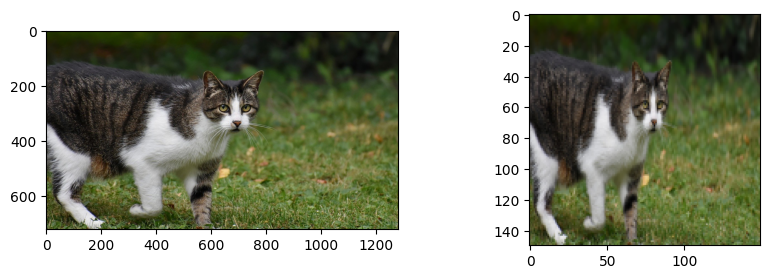

In [29]:
img = cv2.imread('cat2.jpg')[:,:,::-1]
img2 = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()

In [30]:
best_model.predict(img2.reshape(-1,150,150,3))

1/1 [==============================] - 0s 26ms/step


array([[0.]], dtype=float32)

In [31]:
for fname in up.keys():
    img = cv2.imread(fname)[:,:,::-1]
    img2 = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
    classes = best_model.predict(img2.reshape(-1,150,150,3), verbose=0)
    print(f"{classes[0,0]:.4f} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")

0.0001 cat1.jpg is a cat
0.0000 cat2.jpg is a cat
0.0000 cat3.png is a cat
1.0000 dog1.jpg is a dog
1.0000 dog2.jpg is a dog
1.0000 dog3.jpg is a dog
